In [7]:
# pip install tritonclient

In [8]:
# pip install geventhttpclient

In [8]:
import argparse
import numpy as np
import sys
from functools import partial
import os

import tritonclient.grpc as tritongrpcclient
import tritonclient.grpc.model_config_pb2 as mc
import tritonclient.http as tritonhttpclient

In [9]:
def bar_plot(ax, data, colors=None, total_width=0.8, single_width=1, legend=True):
    """Draws a bar plot with multiple bars per data point.

    Parameters
    ----------
    ax : matplotlib.pyplot.axis
        The axis we want to draw our plot on.

    data: dictionary
        A dictionary containing the data we want to plot. Keys are the names of the
        data, the items is a list of the values.

        Example:
        data = {
            "x":[1,2,3],
            "y":[1,2,3],
            "z":[1,2,3],
        }

    colors : array-like, optional
        A list of colors which are used for the bars. If None, the colors
        will be the standard matplotlib color cyle. (default: None)

    total_width : float, optional, default: 0.8
        The width of a bar group. 0.8 means that 80% of the x-axis is covered
        by bars and 20% will be spaces between the bars.

    single_width: float, optional, default: 1
        The relative width of a single bar within a group. 1 means the bars
        will touch eachother within a group, values less than 1 will make
        these bars thinner.

    legend: bool, optional, default: True
        If this is set to true, a legend will be added to the axis.
    """

    # Check if colors where provided, otherwhise use the default color cycle
    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Number of bars per group
    n_bars = len(data)

    # The width of a single bar
    bar_width = total_width / n_bars

    # List containing handles for the drawn bars, used for the legend
    bars = []

    # Iterate over all data
    for i, (name, values) in enumerate(data.items()):
        # The offset in x direction of that bar
        x_offset = (i - n_bars / 2) * bar_width + bar_width / 2

        # Draw a bar for every value of that type
        for x, y in enumerate(values):
            bar = ax.bar(x + x_offset, y, width=bar_width * single_width, color=colors[i % len(colors)])

        # Add a handle to the last drawn bar, which we'll need for the legend
        bars.append(bar[0])

    # Draw legend if we need
    if legend:
        ax.legend(bars, data.keys())

def plot_latency(times: list, batch_sizes: list):
    means, medians = [np.mean(i) for i in times], [np.median(i) for i in times]
    plt.figure(figsize=(16, 6))
    plt.style.use('ggplot')

    plt.title('Latency (lower is better)')
    plt.bar(
        [str(i) for i in batch_sizes], 
        [a for a, b in zip(means, batch_sizes)],
        label='mean'
    )

    plt.bar(
        [str(i) for i in batch_sizes], 
        [a for a, b in zip(medians, batch_sizes)],
        label='median'
    )

    plt.xlabel('~num parallel requests')
    plt.ylabel('sec.')

    plt.legend()
    plt.show()
    
def plot_total_time(total_times: list, batch_sizes: list):
    plt.figure(figsize=(16, 6))
    plt.style.use('ggplot')

    plt.title('Total time (lower is better)')

    plt.bar(
        [str(i) for i in batch_sizes], 
        [a / b for a, b in zip(total_times, batch_sizes)]
    )

    plt.xlabel('~num parallel requests')
    plt.ylabel('sec.')
    plt.show()

def cross_plot_latency(model_times: dict, batch_sizes: list, agg = np.mean):
    fig, ax = plt.subplots(figsize=(16, 6), ncols=1, nrows=1)
    plt.style.use('ggplot')

    plt.title('Latency (lower is better)')
    bar_plot(ax, {k: [agg(i) for i in v] for k, v in model_times.items()})
    ax.set_xticks([i for i in range(len(batch_sizes))])
    ax.set_xticklabels([str(i) for i in batch_sizes])
    plt.xlabel('~num parallel requests')
    plt.ylabel('sec.')

    
def cross_plot_total_time(model_times: dict, batch_sizes: list):
    fig, ax = plt.subplots(figsize=(16, 6), ncols=1, nrows=1)
    plt.style.use('ggplot')

    plt.title('Total time (lower is better)')
    bar_plot(ax, {k: [i / b for i, b in zip(v, batch_sizes)] for k, v in model_times.items()})
    ax.set_xticks([i for i in range(len(batch_sizes))])
    ax.set_xticklabels([str(i) for i in batch_sizes])
    plt.xlabel('~num parallel requests')
    plt.ylabel('sec.')

In [10]:
import tritonclient.http as triton_client

In [11]:
from multiprocessing import Process, Queue
import time
import random
import tensorflow as tf

MODEL_NAME = 'FastPitch'
MODEL_VERSION = '1'
TEXTNAME = "TEXT"
OUTPUT_NAME = 'output_0'

class TukTukEpta(Process):
    
    def __init__(
        self, 
        work_queue: Queue, 
        time_queue: Queue, 
        length: int = 100, 
        model_name: str = MODEL_NAME
    ):
        super().__init__()
        self.client = None
        self.model_metadata = None
        self.model_config = None
        self.length = length
        
        self.model_name = model_name
        
        self.work_queue = work_queue
        self.time_queue = time_queue
    
    @staticmethod
    def construct_inputs(length: int, count: int) -> list:
        inputs = []
        for _ in range(count):
            input_string = ''.join(random.choices("абвгвжлппрашыфл", k=length))
            model_in = [
                tritonhttpclient.InferInput(TEXTNAME, [1], "BYTES"),
            ]
            model_in[0].set_data_from_numpy(np.asarray(input_string, dtype="object").reshape([1]))
            inputs.append(model_in)
        return inputs
    
    def infer_input(self, in_data: tritonhttpclient.InferInput):
        response = self.client.infer(
            self.model_name,  
            inputs=[*in_data], 
            outputs=[tritonhttpclient.InferRequestedOutput(OUTPUT_NAME,  binary_data=True)]
        )
        return response
    
    def init_client(self):
        self.client = tritonhttpclient.InferenceServerClient(url='localhost:8000')
        self.model_metadata = self.client.get_model_metadata(model_name=self.model_name, model_version=MODEL_VERSION)
        self.model_config = self.client.get_model_config(model_name=self.model_name, model_version=MODEL_VERSION)
    
    def run(self):
        self.init_client()
        inputs = self.construct_inputs(self.length, 1)
        while True:
            
            work = self.work_queue.get()
            if work is None:
                break

            stime = time.perf_counter()
            self.infer_input(inputs[0])
            t = time.perf_counter() - stime
            
            self.time_queue.put(t)

In [12]:
# pip install matplotlib

In [13]:
import matplotlib.pyplot as plt
import time
import numpy as np
import random
from tqdm import tqdm

def test_model(batch_sizes: list, lengths: tuple, times_to_test: int, model_name: str):

    times = []
    total_times = []
    for bs in tqdm(batch_sizes):
        in_queue = Queue()
        out_queue = Queue()
        for _ in range(times_to_test * min(bs, 32)):
            in_queue.put(1)
        for _ in range(bs):
            in_queue.put(None)
            
        workers = [TukTukEpta(
            in_queue, out_queue, random.randint(*length), model_name=model_name
        ) for _ in range(bs)]

        start = time.perf_counter()
        for w in workers:
            w.start()
        for w in workers:
            w.join()
        out_queue.put(None)
        total_times.append(time.perf_counter() - start)

        _times = []
        while True:
            t = out_queue.get()
            if t is None:
                break
            _times.append(t)

        times.append(_times)
    
    return times, total_times


In [20]:
batch_sizes = [1, 2, 4, 16]
length = (100, 100)
times_to_test = 100

time_map = {}
for model in ['ensemble_model']:
    a, b = test_model(batch_sizes, length, times_to_test, model)
    time_map[model] = (a, b)

100%|██████████| 4/4 [00:08<00:00,  2.07s/it]


In [ ]:
name_map = {
    'FastPitch': 'FastPitch-TS-FP16',
    'FastPitchFP32': 'FastPitch-TS-FP32'    
}
for n1, n2 in name_map.items():
    time_map[n2] = time_map[n1]
    del time_map[n1]

Model: ensemble_model


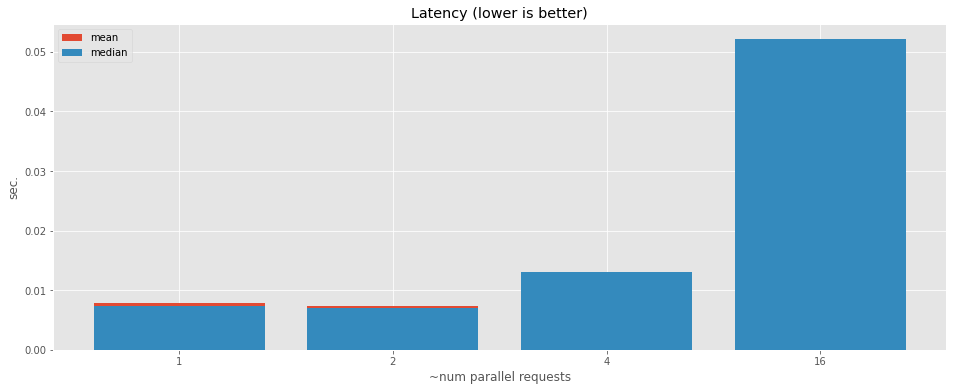

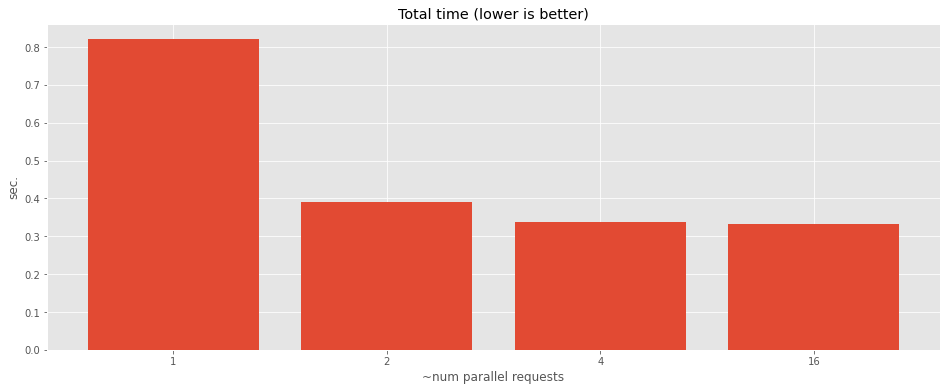

In [22]:
for model, times in time_map.items():
    print('Model:', model)
    plot_latency(times[0], batch_sizes)
    plot_total_time(times[1], batch_sizes)

In [23]:
import collections

model_to_latency = {k: v[0] for k, v in time_map.items()}
model_to_total = {k: v[1] for k, v in time_map.items()}

model_to_latency = collections.OrderedDict(
    sorted(
        model_to_latency.items(), 
        key=lambda x: sum([sum(i) for i in x[1]]),
        reverse=False
    )
)

model_to_total = collections.OrderedDict(
    sorted(
        model_to_total.items(), 
        key=lambda x: sum([i for i in x[1]]),
        reverse=False
    )
)

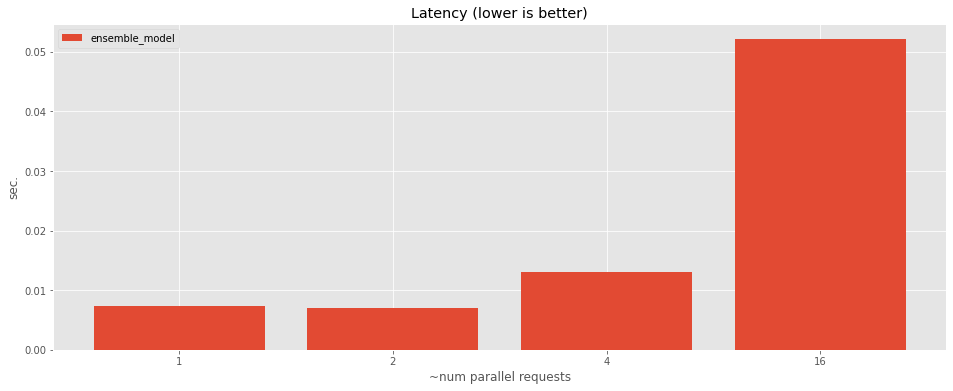

In [24]:
cross_plot_latency(model_to_latency, batch_sizes, agg=np.median)

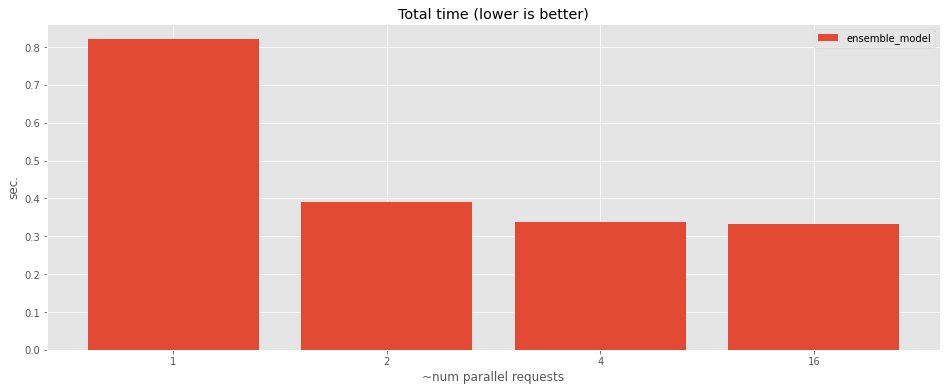

In [25]:
cross_plot_total_time(model_to_total, batch_sizes)